# Imports

In [80]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Read dataset

In [9]:
labels = []
features = []

In [10]:
for ind in range(82):
    file_path = "processed/"+str(ind)+"/"
    with open(file_path+"encounters.json", 'r') as j:
        encounters = json.loads(j.read())

    heart_rate = pd.read_csv(file_path+"heart_rate.csv")
    imu_left_hand = pd.read_csv(file_path+"imu_left_hand.csv")
    imu_right_hand = pd.read_csv(file_path+"imu_right_hand.csv")
    keyboard = pd.read_csv(file_path+"keyboard.csv")
    mouse = pd.read_csv(file_path+"mouse.csv")
    
    for event_num in range(len(encounters)):
        try:
            time = round(encounters[event_num]['time'])
            features.append(np.concatenate((np.array(mouse.iloc[time][['mouse_clicks', 'mouse_movement']]), 
                np.array([keyboard.iloc[time]['buttons_pressed'],]),
                np.array([heart_rate.iloc[time].heart_rate,]),
                np.array(imu_left_hand.iloc[time][['linaccel_x','linaccel_y','linaccel_z','gyro_x','gyro_y','gyro_z']]),
                np.array(imu_right_hand.iloc[time][['linaccel_x','linaccel_y','linaccel_z','gyro_x','gyro_y','gyro_z']]))))
            labels.append(encounters[event_num]['outcome'])
        except Exception:
            pass

In [11]:
len(labels)

1223

In [12]:
len(features)

1223

In [28]:
labels.count(1)

877

In [29]:
labels.count(0)

346

# Split into train and test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, \
                                                    shuffle=True, stratify=labels)

In [52]:
len(X_train)

856

In [53]:
len(X_test)

367

# Normalize

In [54]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Try Random forest

In [71]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

clf = RandomForestClassifier()

grid = {
    'n_estimators':list(range(10,310,10)),
#     'n_estimators':list(range(100,110,10)),
}

gs = GridSearchCV(clf, param_grid=grid, cv=cv)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300]})

In [78]:
rf = gs.best_estimator_
rf

RandomForestClassifier(n_estimators=280)

In [79]:
y_pred_test = rf.predict(X_test)
round(f1(y_test, y_pred_test),3)

0.85

# Try KNN

In [82]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

clf = KNeighborsClassifier()

grid = {
    'n_neighbors':range(3,22,2),
    'weights':['uniform','distance'],
    'p':[1,2]
}

gs = GridSearchCV(clf, param_grid=grid, cv=cv)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 22, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [83]:
knn = gs.best_estimator_
knn

KNeighborsClassifier(n_neighbors=13, p=1)

In [84]:
y_pred_test = knn.predict(X_test)
round(f1(y_test, y_pred_test),3)

0.851

# Look at ROC

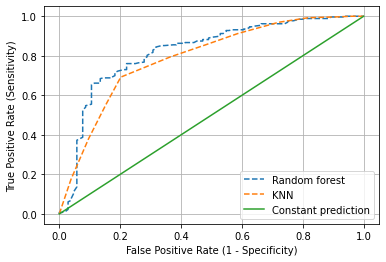

In [85]:
y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf[:,1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn[:,1])
fpr_m, tpr_m, _ = roc_curve(y_test, np.zeros_like(y_pred_proba_rf[:,1]))

# plot the roc curve for the model
plt.plot(fpr_rf, tpr_rf, linestyle="--", label='Random forest')
plt.plot(fpr_knn, tpr_knn, linestyle="--", label='KNN')
plt.plot(fpr_m, tpr_m, linestyle="-", label='Constant prediction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid()
plt.show()

def tpr_by_fpr(tpr, fpr, desired_fpr=0.7):
    assert(len(tpr) == len(fpr))
    return tpr[min(range(len(fpr)), key=lambda i: abs(fpr[i]-desired_fpr))]

In [86]:
round(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]), 3)

0.822

In [87]:
round(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]), 3)

0.79

# Save the best model

In [88]:
with open('model.pkl', 'wb') as fid:
    pickle.dump(rf, fid)
with open('model.pkl', 'rb') as fid:
    loaded = pickle.load(fid)

In [89]:
loaded

RandomForestClassifier(n_estimators=280)